In [1]:
datasets = [
    "ADRB2",
    "AICDA",
    "BRCA1",
    "BRCA2",
    "CALM1",
    "CAR11",
    "CASP3",
    "CASP7",
    "CBS",
    "GDIA",
    "GRB2",
    "HEM3",
    "HMDH",
    "HXK4",
    "KCNE1",
    "KCNH2",
    "MET",
    "MK01",
    "MSH2",
    "MTHR",
    "NPC1",
    "OTC",
    "P53",
    "PAI1",
    "PPARG",
    "PPM1D",
    "PTEN",
    "RAF1",
    "RASH",
    "S22A1",
    "SC6A4",
    "SCN5A",
    "SERC",
    "SHOC2",
    "SRC",
    "SUMO1",
    "SYUA",
    "TADBP",
    "TPK1",
    "TPOR",
    "UBC9",
    "VKOR1",
    "brenan",
    "cas12f",
    "cov2_S",
    "doud",
    "giacomelli",
    "haddox",
    "jones",
    "kelsic",
    "lee",
    "markin",
    "stiffler",
    "zikv_E"]


In [ ]:
import context  # noqa: F401
import pandas as pd
from msalde.ml_util import (
    create_gaussian_mixture,
    calculate_optimal_youden_index
)
from msalde.container import ALDEContainer
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
import matplotlib.pyplot as plt
from notebooks.calibration_analysis import get_dataset_clinvar_results


def plot_gaussian_mixture(axes, x_coords, pdf, data, threshold,
                          dataset, learner):

    axes.hist(data, bins=30, density=True, alpha=0.5, color='gray')
    axes.plot(x_coords, pdf, color='blue', lw=2, label='Fitted GMM density')
    axes.axvline(threshold, color='red', linestyle='--', label='Threshold')
    axes.set_xlabel('Prediction Score')
    axes.set_ylabel('Density')
    axes.set_title(f'{dataset}/{learner}', fontsize=16)
    axes.legend()



def show_gaussian_mixture(repo, external_repo, plotter, axes, config_id,
                          dataset, run_name,
                          learner_label):
    results = repo.get_last_round_scores_by_config_dataset_run(
        config_id=config_id, dataset_name=dataset, run_name=run_name)
    if len(results) == 0:
        return 0
    data = results['prediction_score'].values
    _, x_coords, pdf, threshold = create_gaussian_mixture(data, 2)
    plot_gaussian_mixture(axes, x_coords, pdf, data, threshold,
                          dataset, learner_label)
    return len(results)


def show_roc_curve(repo, external_repo, plotter, axes, config_id, dataset,
                   run_name, learner_label):
    results, num_positive, num_negative = \
        get_dataset_clinvar_results(repo, external_repo,
                                          config_id, dataset, run_name)
    if num_positive < 30 or num_negative < 30:
        return 0
    optimal_youden_index, fpr, tpr, _ = calculate_optimal_youden_index(
            results['label'].values,
            results['prediction_score'].values
    )
    auc = roc_auc_score(results['label'].values, results['prediction_score'].values)
    plotter.plot_roc_curve(axes, fpr, tpr, auc, 
                           fpr[optimal_youden_index],
                           dataset + "/" + learner_label,
                           num_positive, num_negative)
    return len(results)


def show_pr_curve(repo, external_repo, plotter, axes, config_id, dataset,
                   run_name, learner_label):
    results, num_positive, num_negative = \
        get_dataset_clinvar_results(repo, external_repo,
                                          config_id, dataset, run_name)
    if num_positive < 30 or num_negative < 30:
        return 0
    precisions, recalls, _ = precision_recall_curve(
            results['label'].values,
            results['prediction_score'].values
    )
    pr_auc = auc(recalls, precisions)
    plotter.plot_pr_curve(axes, recalls, precisions, pr_auc,
                          dataset + "/" + learner_label,
                          num_positive, num_negative)
    return len(results)


def show_plots(show_plot_func):
    # datasets = ["ADRB2", "PPARG", "SCN5A"]
    # datasets = ["cas12f2"]
    container = ALDEContainer("./config/msaldem.yaml")
    # container = ALDEContainer("./config/msalde.yaml")
    repo = container.query_repository
    external_repo = container.external_repository
    plotter = container.plotter

    datasets_ = datasets # [:5]
    # datasets_ = ["cas12f2"]

    num_rows = len(datasets_)

    fig = plt.figure()
    fig, axes = plt.subplots(num_rows, 3, figsize=(20, 6*len(datasets_)))
    axes = axes.flatten()
    plt.style.use('seaborn-v0_8')
    ind = 0
    for dataset in datasets_:
        if not show_plot_func(repo, external_repo, plotter, axes[ind], 
                                     "c10", dataset, "ESM2_LLR",
                                     "LogLikelihood"):
            continue
        ind += 1
        show_plot_func(repo, external_repo, plotter, axes[ind],
                       "c3_1", dataset, "RF_AL",
                                     "RandomForest AL")
        ind += 1
        show_plot_func(repo, external_repo, plotter, axes[ind],
                       "c3_2", dataset, "RFTRAIN_ALL",
                                     "RandomForest Train20%")
        ind += 1

    for j in range(ind, len(axes)):
        fig.delaxes(axes[j])

    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(hspace=0.5)
    plt.show()

def show_gaussian_mixtures():
    show_plots(show_gaussian_mixture)

def show_roc_curves():
    show_plots(show_roc_curve)

def show_pr_curves():
    show_plots(show_pr_curve)

def show_gaussian_mixtures1():
    datasets = ["ADRB2", "PPARG", "SCN5A"]
    # datasets = ["cas12f2"]
    container = ALDEContainer("./config/msaldem.yaml")
    # container = ALDEContainer("./config/msalde.yaml")
    repo = container.query_repository
    external_repo = container.external_repository

    datasets_ = datasets # [:5]
    # datasets_ = ["cas12f2"]

    num_rows = len(datasets_)

    fig, axes = plt.subplots(num_rows, 3, figsize=(20, 6*len(datasets_)))
    axes = axes.flatten()
    plt.style.use('seaborn-v0_8')
    ind = 0
    for dataset in datasets_:
        if not show_gaussian_mixture(repo, external_repo, axes[ind], 
                                     "c10", dataset, "ESM2_LLR",
                                     "LogLikelihood"):
            continue
        ind += 1
        show_gaussian_mixture(repo, external_repo, axes[ind],
                              "c3_1", dataset, "RF_AL",
                              "RandomForest AL")
        ind += 1
        show_gaussian_mixture(repo, external_repo, axes[ind],
                              "c3_2", dataset, "RF_TRAINALL",
                                     "RandomForest Train20%")
        ind += 1

    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(hspace=0.5)
    plt.show()



<Figure size 800x550 with 0 Axes>

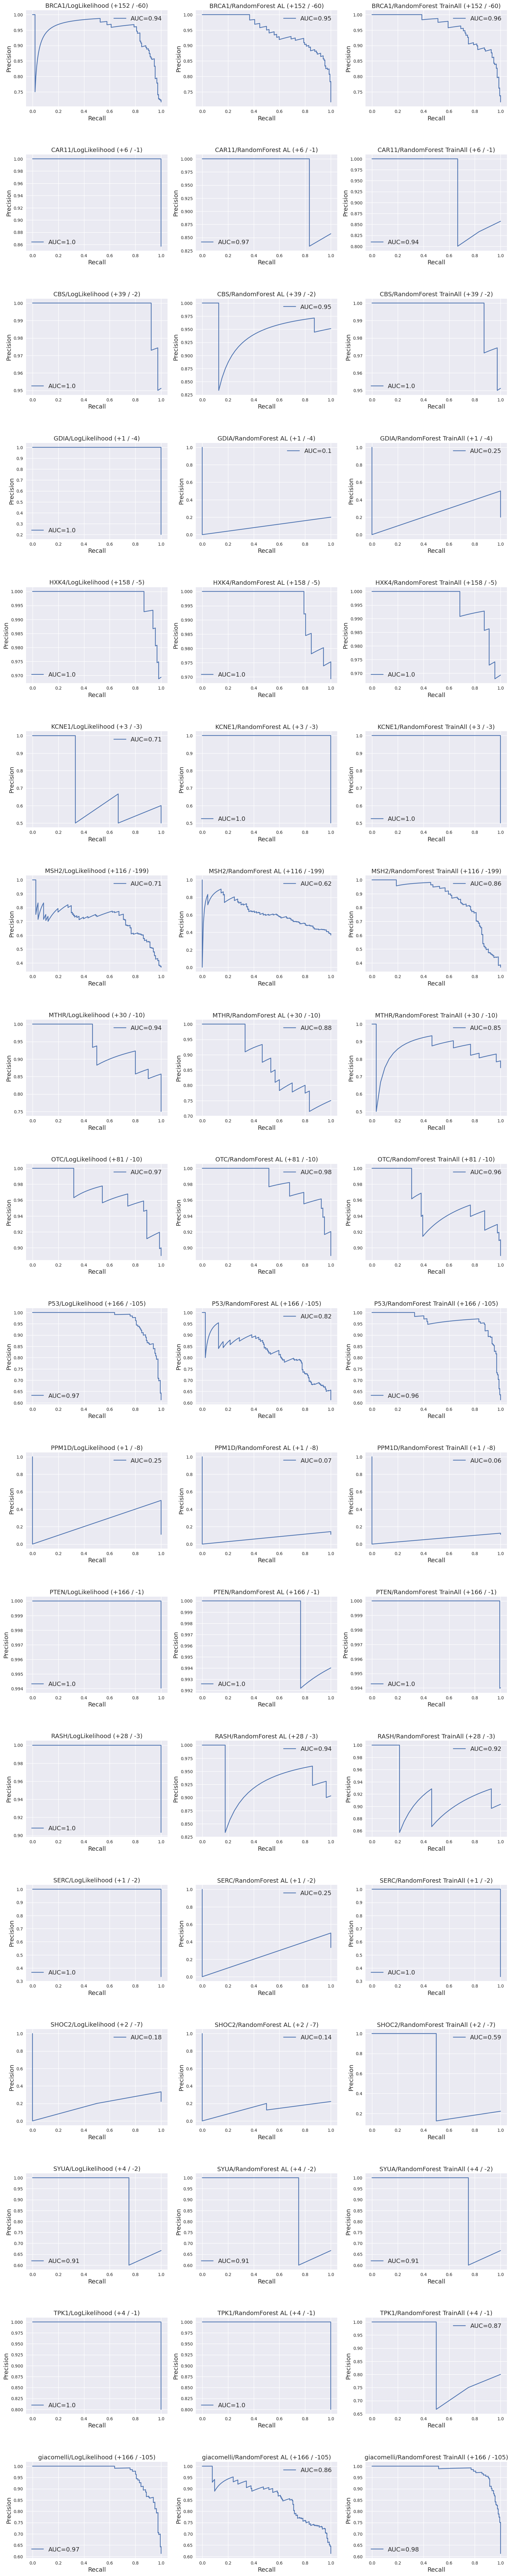

In [12]:
# show_roc_curves()
show_pr_curves()
# show_gaussian_mixtures()

In [ ]:
show_roc_curves()

/tmp/ipykernel_2356/1677848018.py:28: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


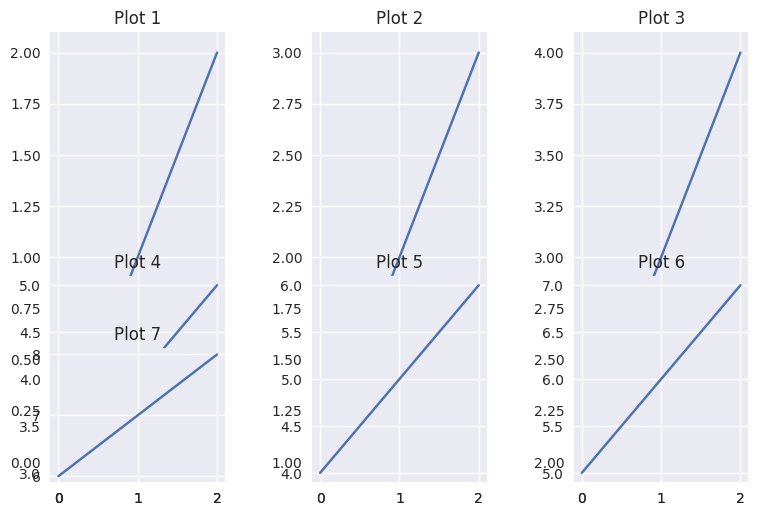

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()

ncols = 3
nrows = 0
axes = []

# Function to add a new subplot dynamically
def add_subplot(fig, axes, nrows, ncols):
    # Increment row count if needed
    total_plots = len(axes) + 1
    nrows = int(np.ceil(total_plots / ncols))
    
    # Position of new subplot
    index = total_plots
    ax = fig.add_subplot(nrows, ncols, index)
    axes.append(ax)
    return ax, nrows

# Example: add 7 subplots one by one
for i in range(7):
    ax, nrows = add_subplot(fig, axes, nrows, ncols)
    ax.plot([0, 1, 2], [i, i+1, i+2])
    ax.set_title(f"Plot {i+1}")

    plt.tight_layout()
plt.show()
